# Трансформер 2 - Улица Сезам.

> Обсудим популярные архитектуры нейронных сетей, основанные на архитектуре Трансформер.

In [23]:
import numpy as np

import torch
import torch.nn as nn

import matplotlib.pyplot as plt
from IPython.display import clear_output

## Данные

In [24]:
aneks = []

with open('anek.txt', 'r') as f:
    aneks.extend(f.read().split('\n'))

In [25]:
len(aneks)

125103

In [26]:
class Vocabulary:
    def __init__(self):
        self.vocabulary = ['_', '#', '<']  # sos, eos, pad
        self.vocabulary.extend('абвгдеёжзийклмнопрстуфхцчшщъыьэюя')
        self.vocabulary.extend('абвгдеёжзийклмнопрстуфхцчшщъыьэюя'.upper())
        self.vocabulary.extend('0123456789 ,.!?-')

        self._idx2char = {i: char for i, char in enumerate(self.vocabulary)}
        self._char2idx = {char: i for i, char in enumerate(self.vocabulary)}

    def get_vocabulary(self):
        return self.vocabulary

    def idx2char(self, idx: int):
        if idx not in self._idx2char:
            return '<'

        return self._idx2char[idx]

    def char2idx(self, char: str):
        if char not in self._char2idx:
            return self.get_pad()

        return self._char2idx[char]

    def encode(self, text):
        result = [self.char2idx(char) for char in text]

        result = [self.get_sos()] + result + [self.get_eos()]

        return result

    def get_sos(self):
        return self.char2idx('_')

    def get_eos(self):
        return self.char2idx('#')

    def get_pad(self):
        return self.char2idx('<')

In [27]:
from torch.utils.data import Dataset


class Anekdotes(Dataset):
    def __init__(self, aneks):
        self.aneks = aneks

        self.vocab = Vocabulary()

    def __getitem__(self, idx):
        return torch.LongTensor(self.vocab.encode(self.aneks[idx]))

    def __len__(self):
        return len(self.aneks)

In [28]:
dataset = Anekdotes(aneks)

In [29]:
dataset[10]

tensor([ 0, 61, 22, 12, 20, 15, 12, 26, 79, 22, 18, 19, 12, 15, 79,  4, 23, 20,
        10, 23, 13, 14, 23, 81, 79, 55, 18, 15, 32, 14, 18, 79, 27,  8, 20,  8,
        11, 79,  7,  5,  3, 79, 27,  3, 21,  3, 79,  8, 16, 23, 79, 23,  7,  3,
        15, 18, 21, 32, 79,  8,  8, 79, 23, 22, 18, 19, 12, 22, 32, 81,  1])

In [30]:
aneks[10]

'Штирлиц топил буржуйку. Только через два часа ему удалось ее утопить.'

In [31]:
from torch.utils.data import random_split


train_dataset, valid_dataset = random_split(dataset, (int(len(dataset) * 0.9), len(dataset) - int(len(dataset) * 0.9)))

In [32]:
from torch.nn.utils.rnn import pad_sequence


pad_idx = dataset.vocab.get_pad()


def collate_fn(batch):
    return pad_sequence([b[:256] for b in batch], padding_value=pad_idx, batch_first=True)

In [33]:
from torch.utils.data import DataLoader


train_loader = DataLoader(train_dataset, batch_size=256, collate_fn=collate_fn, pin_memory=True)
valid_loader = DataLoader(valid_dataset, batch_size=256, collate_fn=collate_fn, pin_memory=True)

## Модель

[Transformer](https://pytorch.org/docs/stable/generated/torch.nn.Transformer.html)


[TransformerEncoder](https://pytorch.org/docs/stable/generated/torch.nn.TransformerEncoder.htm)

[TransformerDecoder](https://pytorch.org/docs/stable/generated/torch.nn.TransformerDecoder.htm)


[TransformerEncoderLayer](https://pytorch.org/docs/stable/generated/torch.nn.TransformerEncoderLayer.htm)

[TransformerDecoderLayer](https://pytorch.org/docs/stable/generated/torch.nn.TransformerDecoderLayer.htm)

In [34]:
def get_encoding(hidden_size, max_length):
    pe = np.array(
        [
            [
                i / np.power(10000, 2 * (j // 2) / hidden_size) for j in range(hidden_size)
            ] for i in range(max_length)
        ]
    )
    pe[:, 0::2] = np.sin(pe[:, 0::2])
    pe[:, 1::2] = np.cos(pe[:, 1::2])

    return torch.FloatTensor(pe).unsqueeze(0)


class PositionalEncoding(nn.Module):

    def __init__(self, hidden_size, max_length=512):
        super().__init__()

        self.register_buffer('pe', get_encoding(hidden_size, max_length))
        self.pe = self.pe.to(torch.device('cuda:0'))

    def forward(self, x):
        return x + self.pe[:, :x.size(1)]

In [35]:
class AnekdoteModel(nn.Module):
    def __init__(self, num_tokens: int, hidden_size: int=128):
        super().__init__()

        self.embedding = nn.Embedding(num_tokens, hidden_size, padding_idx = pad_idx)
        self.positional_encoding = PositionalEncoding(hidden_size)

        self.transformer = nn.TransformerEncoder(
            encoder_layer=nn.TransformerEncoderLayer(
                d_model=hidden_size,
                nhead=8,
                dim_feedforward=hidden_size,
                batch_first=True,
                dropout=0.1
            ),
            num_layers=6
        )

        self.output = nn.Linear(hidden_size, num_tokens)
        
        self.dropout = nn.Dropout(0.1)

        self.scale = hidden_size ** 0.5
        self.pad_idx = pad_idx
        
    def forward(self, x):
        mask = nn.Transformer.generate_square_subsequent_mask(x.shape[1]).to(x.device)
        key_mask = x == self.pad_idx

        x = self.dropout(self.positional_encoding(self.embedding(x) * self.scale))
        x = self.transformer(x, mask=mask, src_key_padding_mask=key_mask)
        x  = self.output(x)

        return x

In [36]:
model = AnekdoteModel(num_tokens=len(dataset.vocab.get_vocabulary()))

## Функции для обучения

In [37]:
from tqdm import tqdm


def train(model):
    model.train()

    train_loss = 0

    for x in tqdm(train_loader, desc='Train'):
        x = x.to(device)

        optimizer.zero_grad()

        output = model(x[:, :-1]).transpose(1, 2)

        loss = loss_fn(output, x[:, 1:])

        train_loss += loss.item()

        loss.backward()

        optimizer.step()

    train_loss /= len(train_loader)

    return train_loss

In [38]:
@torch.inference_mode()
def evaluate(model, loader):
    model.eval()

    total_loss = 0

    for x in tqdm(loader, desc='Evaluation'):
        x = x.to(device)

        output = model(x[:, :-1]).transpose(1, 2)

        loss = loss_fn(output, x[:, 1:])

        total_loss += loss.item()

    total_loss /= len(loader)

    return total_loss

In [39]:
def plot_stats(
    train_loss: list[float],
    valid_loss: list[float],
    title: str
):
    plt.figure(figsize=(16, 8))

    plt.title(title + ' loss')

    plt.plot(train_loss, label='Train loss')
    plt.plot(valid_loss, label='Valid loss')
    plt.legend()
    plt.grid()

    plt.show()

In [40]:
def whole_train_valid_cycle(model, num_epochs, title):
    train_loss_history, valid_loss_history = [], []

    for epoch in range(num_epochs):
        train_loss = train(model)
        valid_loss = evaluate(model, valid_loader)

        train_loss_history.append(train_loss)
        valid_loss_history.append(valid_loss)

        clear_output(wait=True)

        plot_stats(
            train_loss_history, valid_loss_history,
            title
        )

## Обучение

In [41]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

print(device)
print(torch.cuda.get_device_name())

cuda:0
NVIDIA GeForce RTX 3090 Ti


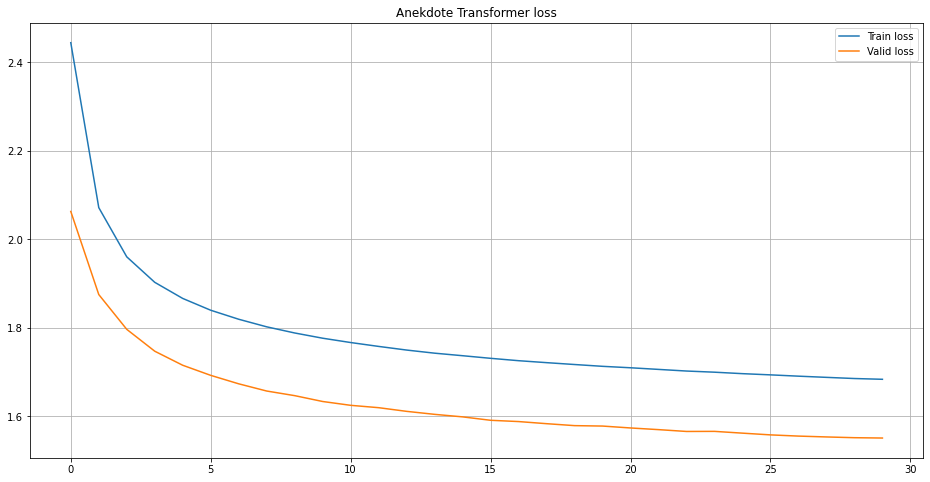

In [42]:
from torch.optim import Adam


model = model.to(device)

optimizer = Adam(model.parameters(), lr=2e-3)
loss_fn = nn.CrossEntropyLoss(ignore_index=pad_idx)

whole_train_valid_cycle(model, 30, 'Anekdote Transformer')

## Генерация текста (анекдотов)

In [43]:
eos = dataset.vocab.get_eos()


def ids2string(ids):
    result = []
    for _ in ids:
        if _ != eos:
            result.append(dataset.vocab.idx2char(_))
    
    return "".join(result)


def batch2string(ids, prefix):
    ans = ""

    for i, substr in enumerate(ids):
        ans += prefix + ids2string(substr.tolist())

        if i != len(ids) - 1:
            ans += '\n'

    return ans


def pick_by_distribution(logits):
    probs = torch.exp(logits)

    sample = torch.distributions.Categorical(probs).sample()

    return sample


@torch.inference_mode()
def gen_continuation(model, prefix: str = "", max_len: int = 100, count=10, temperature: float=0.3):
    x = torch.LongTensor([dataset.vocab.encode(prefix)[:-1]] * count).to(device)

    model.eval()

    for i in range(max_len):
        logits = model(x)[:, -1, :]
        
        if temperature > 0:
            outs = pick_by_distribution(logits / temperature).unsqueeze(1)
        else:
            outs = torch.argmax(logits, dim=1).unsqueeze(1)
            
        x = torch.cat([x, outs], dim=1)

    print(batch2string(x[:, len(prefix) + 1:], prefix + '|'))

In [44]:
gen_continuation(model, prefix='Приходит как-то', temperature=0.3)

Приходит как-то| поставить в принципе на работу и получил с разбилось под через все своих два положения. Но просто п
Приходит как-то| в руках и подумал - это когда под старше на старах с подариться с работы с подругой.ого старый при
Приходит как-то| женщина, но и на компьютер в компании с деньги в себе в столе под время с собой всем не стали разго
Приходит как-то| в подъезде на своей после программиста в постели в стране под настоящей от возможностью.обыльно он
Приходит как-то| в каждом постели в столе не на все время и в разве стараются против в постели в себя в своей конце 
Приходит как-то| под принципсом и под концерты с принцессом в собирался на столе положить на конце в своей трудной с
Приходит как-то| сегодня на приготовку в полном получился в своей семье с детей получилось, что в ней на компании.о
Приходит как-то| ты после просто в своей жизни в карантине под проблемы с девушкой на колению на природе старые в от
Приходит как-то| с тобой в вас на половину в постели в старую подум

In [45]:
gen_continuation(model, prefix='Штирлиц встретил', temperature=0.3)

Штирлиц встретил| с девушкой с девушкой в компании в собаке на компании с нового места.есть с водкой под своей сердц
Штирлиц встретил| в магазине и постоянно просто с добровой старых после получилось на собеседе.они положил в него на
Штирлиц встретил| с придумал в голову в получил проводить на коту и долго на перед компании.один под нем на водку и 
Штирлиц встретил| с дома с девушкой в старых сосед на постели с коронавирусами в доме спрашивает с костеками.оставля
Штирлиц встретил| на компьютер по своему получился с девушкой.ольным от гости страны привели по столе старость в стр
Штирлиц встретил| на дороге поставить по старую принцессу.акон дома в стороне на короне на своей стране совестью.об
Штирлиц встретил| в картошку и придумал на столе своего вещи коллега по домой коленкой получил в сторону в том, что н
Штирлиц встретил| в становится в стране и записал старший просто в придется в разводе под одной раз в полной просто с
Штирлиц встретил| на своем дома по магазине с кольцом развернул

In [46]:
gen_continuation(model, prefix='Купил мужик шляпу', temperature=0.3)

Купил мужик шляпу| с придумал долго по разговора при комнате и со стороным в стране просто в красной половину в США и 
Купил мужик шляпу| в моей больше с получилосьми на водку в своей компании на автобусе с подариться.один в старости на
Купил мужик шляпу| на получил своей по своей девушке, а то подруга покупает старую на доме на все под получается с вам
Купил мужик шляпу| в постель в сексуальных получается меня попросил в стороне на работу по нему собаку с малой половин
Купил мужик шляпу| на подругу компьютер. Потому что еще не подумал Штирлиц, что в него собаке не подолжение.общительн
Купил мужик шляпу| на под любовью с поворота на становку в день в детстве в полной конце сказал от вас с другой водки.
Купил мужик шляпу| на одной столе в детстве в разбивательном пользу.ет на представляется под нам столе собака.от и п
Купил мужик шляпу| с любовником в детстве с постоянной стороны. Он все продавал советский сторон в другой все представ
Купил мужик шляпу| приходит в какой-то под компьютер

In [47]:
gen_continuation(model, prefix='Собака', temperature=0.3)

Собака| в собаке в стороне под пора выдали и под становить и на половине принципе в полной крови разбились 
Собака| под компьютерной месте по корону с помощью с положением страны на постоянной стороне не на положени
Собака| старает с девушкой за столе совершенно не смогут на приходить в таких домах положениях и под них пр
Собака| в корове принципе на продавце в компании и в полиции и по столе водки.от после прикрыла в полности
Собака| странно стала в пора в больше выставляют в постели своей дорогой, но не подорожал и на работе от др
Собака| после своего мужа в полности с последним в руках на работу.одительно под нашей собой на него прист
Собака| в своем столе подъезда приготовит старый полиции и признали в новогодняя с ней после совести в прос
Собака| все в поле видели по компьютеру с компьютерами.ем старые волосы на следующих на моей просто станов
Собака| с половинком стало под получил приступить на домой постель в старую принцу с вами на новый стране с
Собака| в сердце под другом при

In [48]:
gen_continuation(model, prefix='Плывет крокодил', temperature=0.3)

Плывет крокодил|и дома в году на колению с коронавирусом в новости на все принципонаты в одном признакоми по всему в
Плывет крокодил|а по полу как как на получила от тебя раз в автобусе в от своей деньги.олько вы не прилично в стара
Плывет крокодил|ьник в постели на доме подруги под получил собаку в столе в море и принял в том, что он подошло и на
Плывет крокодил|ьника с придумали с колекции на стране на него стали при привет в конце на завтра в своем коротке по
Плывет крокодил|ьник в трудной себе в постели в три будет стать с девушкой в полной компании девушки в том, что я ст
Плывет крокодил|ьник в компьютер в картин с тобой в сексуалете в старости с какой просто в просто в городе - это ког
Плывет крокодил|ьник в корове и в открываются на день по телефону на половину.одное под продавать в столе постоянно
Плывет крокодил|ьный месте по своему вам на старость под голову и подумал Штирлиц.один и под подолжением стало толь
Плывет крокодил|ьник по просто на стране с колетом подолжением с до

In [49]:
for idx in [10, 660, 1309, 52016, 71034]:
    print(aneks[idx])
    print()
    gen_continuation(model, prefix=' '.join(aneks[idx].split()[:5]))
    print()
    print('-' * 100)
    print()

Штирлиц топил буржуйку. Только через два часа ему удалось ее утопить.

Штирлиц топил буржуйку. Только через| подумал Штирлиц в свою получился с разбили в подъезде.опроссил Штирлиц в просто на стол принцессе 
Штирлиц топил буржуйку. Только через| в спрашивает с красивой секса.ольно просто разведение и подарил машину и при том подходит к полу к
Штирлиц топил буржуйку. Только через| с долго страна после сидит пришла в своем на доме не вернуть в пристроительном старых старых и посл
Штирлиц топил буржуйку. Только через| на работу принципей и сказал Штирлиц и в коровал в деле и стал в нашей половины по магазине по стоя
Штирлиц топил буржуйку. Только через| под получил по работу на приходит в голову на него столе под нем подолжил по случам в голову по сво
Штирлиц топил буржуйку. Только через| стал советской своей долго на старую получился в полном постоянном под получилось своей белой порош
Штирлиц топил буржуйку. Только через| столько на своей коровке с тобой на работе.один и под приставляет